# Steady-state problems

This notebook outlines the solution and differentiation of steady-state problems using bt_ocean. The key approach used is *implicit* differentiation. For further details on implicit differentiation see

  - Andreas Griewank and Andrea Walther, 'Evaluating derivatives', second edition, Society for Industrial and Applied Mathematics, 2008, ISBN: 978-0-898716-59-7, chapter 15
  - Bruce Christianson, 'Reverse accumulation and attractive fixed points', Optimization Methods and Software 3(4), pp. 311&ndash;326 1994, doi: https://doi.org/10.1080/10556789408805572
  - Zico Kolter, David Duvenaud, and Matt Johnson, 'Deep implicit layers - neural ODEs, deep equilibirum models, and beyond', https://implicit-layers-tutorial.org/ [accessed 2024-08-26], chapter 2

## Forward problem

Here we consider a non-linear Stommel problem with a single gyre. We start by configuring the model.

In [1]:
%matplotlib inline

from bt_ocean.model import CNAB2Solver
from bt_ocean.parameters import parameters, tau_0, rho_0, D

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial

jax.config.update("jax_enable_x64", True)

n_hour = 2
parameters = dict(parameters)
parameters.update({"N_x": 64,
                   "N_y": 64,
                   "dt": 3600 / n_hour,
                   "r": 0.1 * parameters["beta"] * parameters["L_y"],
                   "nu": 0})


def Q(grid):
    return -((tau_0 * jnp.pi / (D * rho_0 * 2 * grid.L_y))
            * jnp.cos(jnp.pi * grid.Y / (2 * grid.L_y)))


model = CNAB2Solver(parameters)
model.fields["Q"] = Q(model.grid)

We now solve to steady-state. Rather than writing our own time loop we can use the `steady_state_solve` method. Under-the-hood this timesteps the model until an approximate steady-state is reached.

(D * model.fields['psi'] / 1.0e6).max()=Array(10.15279929, dtype=float64)


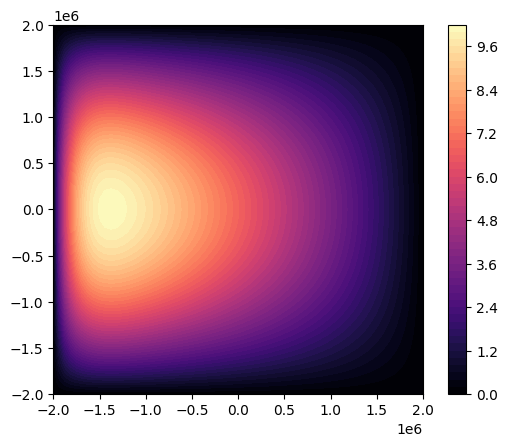

In [2]:
model.steady_state_solve(tol=1.0e-5)

plt.figure()
plt.contourf(model.grid.X, model.grid.Y, D * model.fields["psi"] / 1.0e6, 64, cmap="magma")
plt.gca().set_aspect(1)
plt.colorbar()

print(f"{(D * model.fields['psi'] / 1.0e6).max()=}")

We see a classic Stommel gyre solution, with a transport of approximately $10$ Sv.

## Autodiff

We now differentiate the transport with respect to the wind forcing profile $Q$ appearing on the right-hand-side of the barotropic vorticity equation. We write a single function which computes the diagnostic. Under-the-hood this applies *implicit* differentiation, constructing a fixed-point iteration to solve an associated adjoint problem.

transport=Array(10.15350367, dtype=float64)


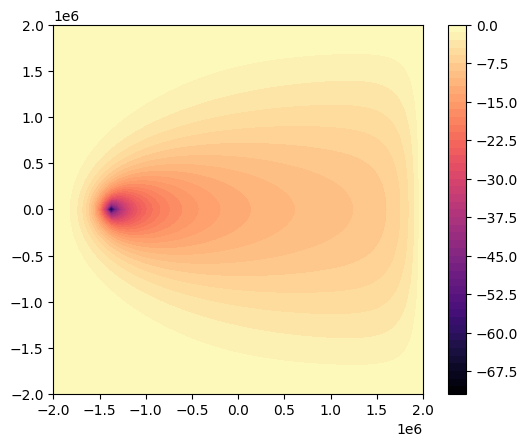

In [3]:
def forward(Q):
    model = CNAB2Solver(parameters)
    model.fields["Q"] = Q
    model.steady_state_solve(tol=1.0e-6)
    return D * model.fields["psi"].max() / 1.0e6


transport, vjp = jax.vjp(forward, model.fields["Q"])
print(f"{transport=}")

dtransport_dual, = vjp(1.0)
dtransport_primal = dtransport_dual / model.grid.W

plt.figure()
plt.contourf(model.grid.X, model.grid.Y, dtransport_primal, 64, cmap="magma")
plt.gca().set_aspect(1)
plt.colorbar()

Let's perform a simple check against finite differencing.

In [4]:
eta = ((tau_0 * jnp.pi / (D * rho_0 * 2 * model.grid.L_y))
       * jnp.sin(jnp.pi * (model.grid.X + model.grid.L_x) / (2 * model.grid.L_x))
       * jnp.sin(jnp.pi * (model.grid.Y + model.grid.L_y) / (2 * model.grid.L_y)))
dtransport_dual_eta = jnp.tensordot(dtransport_dual, eta)
print(f"{dtransport_dual_eta=}")

eps = 1.0e-5
dtransport_dual_eta_fd = (forward(model.fields["Q"] + eps * eta) - forward(model.fields["Q"] - eps * eta)) / (2 * eps)
print(f"{dtransport_dual_eta_fd=}")
assert abs(dtransport_dual_eta - dtransport_dual_eta_fd) < 1.0e-3 * abs(dtransport_dual_eta_fd)

dtransport_dual_eta=Array(-7.43007841, dtype=float64)


dtransport_dual_eta_fd=Array(-7.43041908, dtype=float64)


## Custom terms

We can also add further terms, and differentiate with respect to extra parameters. Here we differentiate with respect to a perturbation to the bottom drag parameter.

transport=Array(10.15350367, dtype=float64)


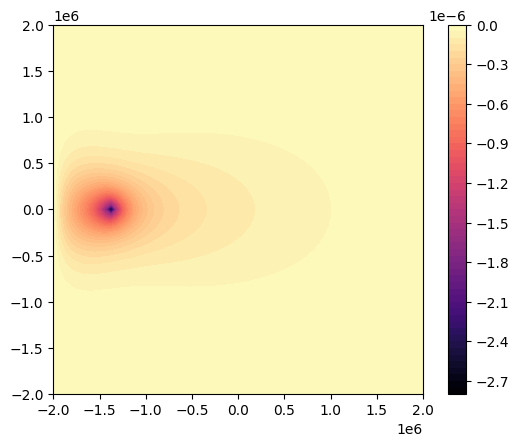

In [5]:
def forward(Q, r):
    def update(model, r):
        model.fields["Q"] = Q - (r - model.r) * model.fields["zeta"]

    model = CNAB2Solver(parameters)
    model.steady_state_solve(r, update=update, tol=1.0e-6)
    return D * model.fields["psi"].max() / 1.0e6


r = jnp.full_like(model.fields["Q"], model.r)
transport, vjp = jax.vjp(partial(forward, model.fields["Q"]), r)
print(f"{transport=}")

dtransport_dual, = vjp(1.0)
dtransport_primal = dtransport_dual / model.grid.W

plt.figure()
plt.contourf(model.grid.X, model.grid.Y, dtransport_primal, 64, cmap="magma")
plt.gca().set_aspect(1)
plt.colorbar()

We can again compare against the result from finite differencing.

In [6]:
eta = (model.r
       * jnp.sin(jnp.pi * (model.grid.X + model.grid.L_x) / (2 * model.grid.L_x))
       * jnp.sin(jnp.pi * (model.grid.Y + model.grid.L_y) / (2 * model.grid.L_y)))
dtransport_dual_eta = jnp.tensordot(dtransport_dual, eta)
print(f"{dtransport_dual_eta=}")

eps = 1.0e-5
dtransport_dual_eta_fd = (forward(model.fields["Q"], r + eps * eta) - forward(model.fields["Q"], r - eps * eta)) / (2 * eps)
print(f"{dtransport_dual_eta_fd=}")
assert abs(dtransport_dual_eta - dtransport_dual_eta_fd) < 1.0e-3 * abs(dtransport_dual_eta_fd)

dtransport_dual_eta=Array(-2.11698943, dtype=float64)


dtransport_dual_eta_fd=Array(-2.11810811, dtype=float64)
